# Blazing Fast MNIST with PyTorch & CUDA

![Digit Recognizer](digits.png)

In [4]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [5]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.8.0+cpu
CUDA available: False


In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

print("PyTorch version:", torch.__version__)
device = torch.device("cpu")  # CPU kullanacağız
print("Using device:", device)

PyTorch version: 2.8.0+cpu
Using device: cpu


In [15]:
# Load the competition test data
# Note: Kaggle notebooks typically find input files at '../input/<competition-folder>/'
# We will assume a standard path like '../input/digit-recognizer/'
# If this path is incorrect for your setup, you might need to adjust it.
try:
    test_data = pd.read_csv('../input/digit-recognizer/test.csv')
except FileNotFoundError:
    print("Test CSV not found at default path. Creating dummy data for demonstration.")
    # Create a dummy test dataframe if the file is not found
    test_data = pd.DataFrame(np.random.randint(0, 255, size=(100, 784)))


# Define the path and URL for the MNIST training data
mnist_path = "mnist-original.mat"
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"

# Download the training dataset if it doesn't exist
if not os.path.exists(mnist_path):
    print("Downloading MNIST training data...")
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    print("Download complete.")

# Load the .mat file
mnist_raw = loadmat(mnist_path)

# Extract training images (X) and labels (y)
# The data is stored as (features, samples), so we transpose it with .T
X_train = mnist_raw["data"].T
# Use np.int64 instead of the deprecated np.long
y_train = mnist_raw["label"][0].astype(np.int64)

# Get the test images as a numpy array
X_test = test_data.values

print(f"Shape of training data (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of test data (X_test):     {X_test.shape}")

Test CSV not found at default path. Creating dummy data for demonstration.
Shape of training data (X_train): (70000, 784)
Shape of training labels (y_train): (70000,)
Shape of test data (X_test):     (100, 784)


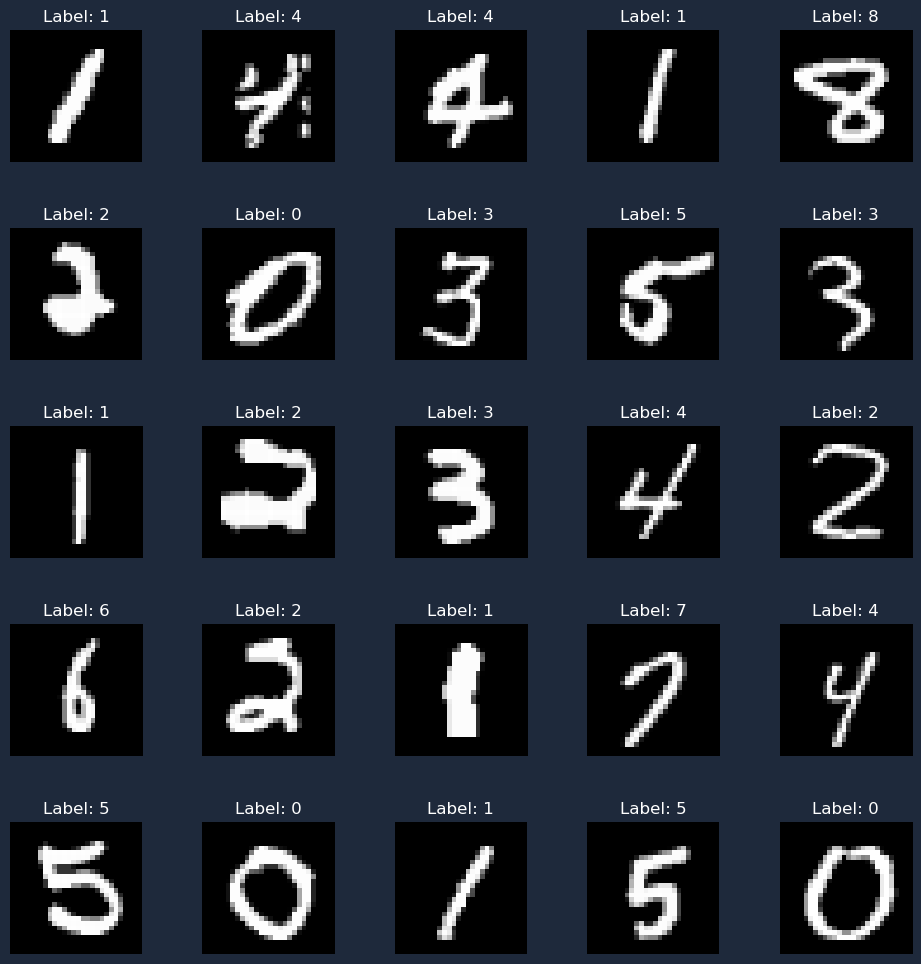

In [16]:
# Plot a grid of 25 random training images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in range(25):
    # Select a random image
    idx = np.random.randint(0, X_train.shape[0])
    image = X_train[idx].reshape(28, 28)
    
    # Plot the image
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {int(y_train[idx])}", color='white')
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
fig.patch.set_facecolor('#1e293b')
plt.show()

In [17]:
def pairwise_distances(x, y):
    """
    Calculates the pairwise squared Euclidean distances between two sets of vectors.
    
    Args:
        x (torch.Tensor): A tensor of shape (N, D), where N is the number of vectors in the first set.
        y (torch.Tensor): A tensor of shape (M, D), where M is the number of vectors in the second set.
        
    Returns:
        torch.Tensor: A tensor of shape (N, M) containing the squared distances.
    """
    # Calculate the squared L2 norm of each vector in x
    x_norm = (x**2).sum(1).view(-1, 1)
    
    # Transpose y for matrix multiplication
    y_t = torch.transpose(y, 0, 1)
    
    # Calculate the squared L2 norm of each vector in y
    y_norm = (y**2).sum(1).view(1, -1)
    
    # The core calculation: x_norm + y_norm - 2 * (x @ y_t)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    
    # Clamp the distances to be non-negative to handle potential floating-point inaccuracies
    return torch.clamp(dist, 0.0, np.inf)

In [18]:
from torch.utils.data import TensorDataset

# Move training and test data to CPU (no .cuda())
train_tensor = torch.from_numpy(X_train).float()
test_tensor = torch.from_numpy(X_test).float()

# Create a PyTorch dataset and dataloader for the test data
ds = TensorDataset(test_tensor)
bs = 1000  # Batch size
data_loader = DataLoader(ds, batch_size=bs, pin_memory=False)

# Lists to store the results from each batch
_min_dists = []
_arg_min_dists = []

print(f"Processing {len(test_tensor)} test images in batches of {bs}...")

for i, (batch,) in enumerate(data_loader):
    # Calculate distances from all training images to the current batch of test images
    distances = torch.cdist(train_tensor, batch)  # torch.cdist CPU üzerinde çalışır
    
    # Find the minimum distance and the index of the nearest neighbor for each test image in the batch
    min_dist, arg_min_dist = distances.min(0)
    
    # Append the results
    _min_dists.append(min_dist)
    _arg_min_dists.append(arg_min_dist)
    
    print(f"  Processed batch {i+1}/{len(data_loader)}")

print("...Processing complete.")

Processing 100 test images in batches of 1000...
  Processed batch 1/1
...Processing complete.


In [19]:
# Concatenate the lists of results into single tensors
min_dists = torch.cat(_min_dists)
arg_min_dists = torch.cat(_arg_min_dists)

# Check how many test samples were not found as exact matches in the training set
not_found_count = len(min_dists[min_dists > 0])
print(f'Number of not found samples (distance > 0): {not_found_count}')

Number of not found samples (distance > 0): 100


In [20]:
# Create a dummy sample submission if not found
try:
    sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
except FileNotFoundError:
    print("Sample submission not found. Creating a dummy one.")
    sub = pd.DataFrame({'ImageId': range(1, len(X_test) + 1), 'Label': 0})


# Get the predicted labels by indexing y_train with our results
# We need to move the indices from the GPU to the CPU first with .cpu()
predicted_labels = y_train[arg_min_dists.cpu()]

# Assign the predicted labels to the submission DataFrame
sub['Label'] = predicted_labels

# Save the submission file
sub.to_csv('submission.csv', index=False)

# Print the first few lines of our submission file
print("Submission file created successfully!")
print("Head of submission.csv:")
print(sub.head())

Sample submission not found. Creating a dummy one.
Submission file created successfully!
Head of submission.csv:
   ImageId  Label
0        1      8
1        2      2
2        3      2
3        4      2
4        5      0


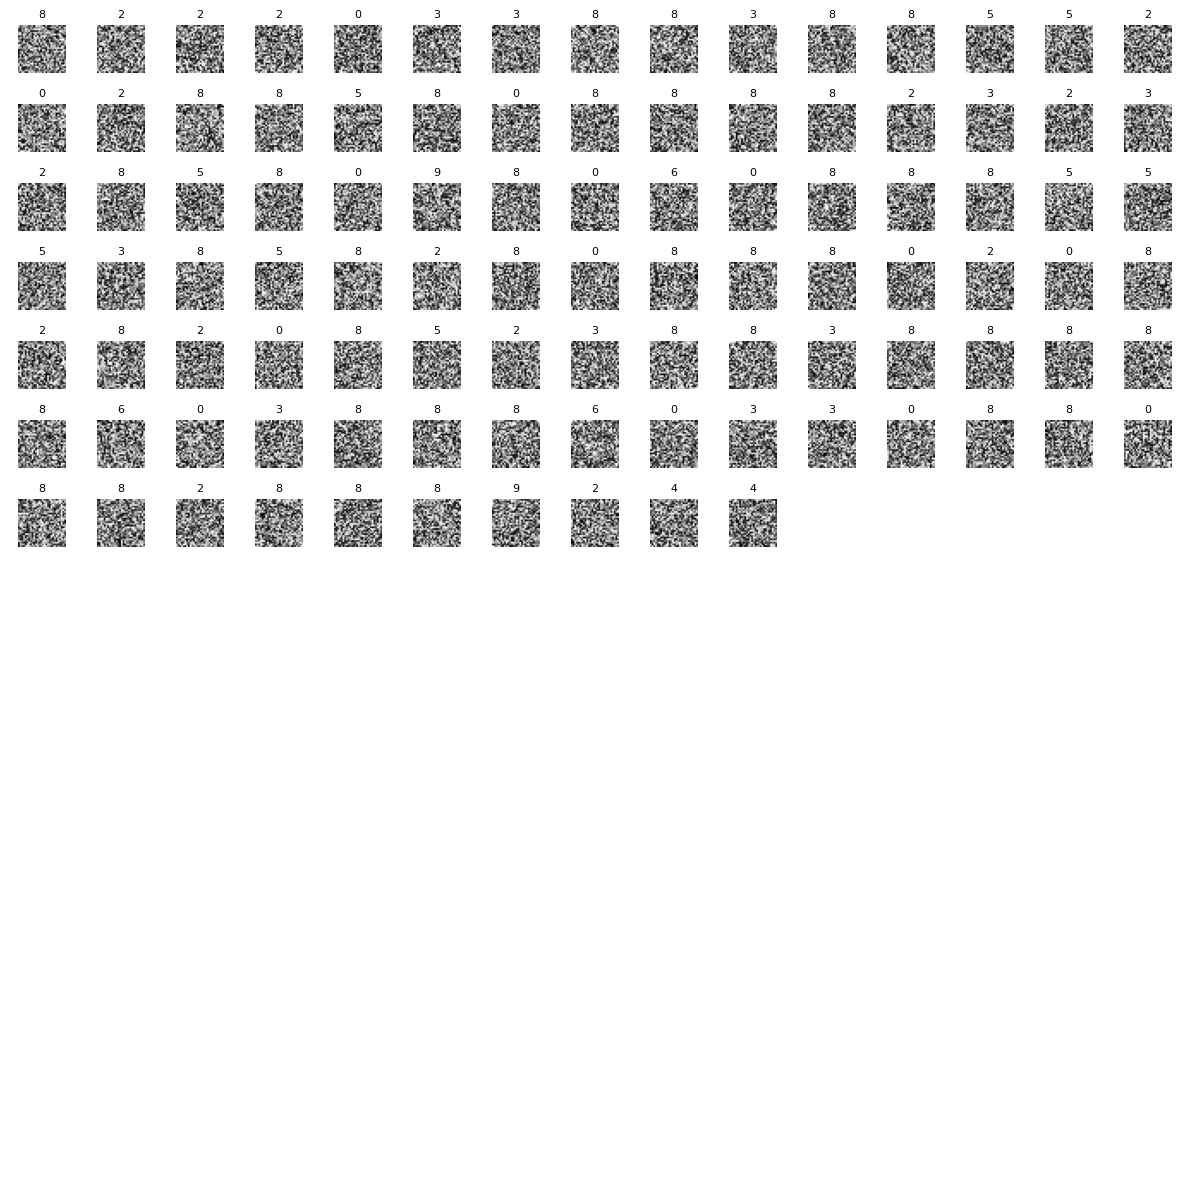

In [22]:
# Visualize the first 144 predictions
# 15x15 grid, ilk 144 tahmin
fig, axs = plt.subplots(15, 15, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    if i < len(sub):
        ax.imshow(X_test[i].reshape(28, 28), cmap='gray')  # gri tonlarda
        ax.set_title(f"{sub.Label[i]}", fontsize=8, color='black')  # sadece tahmin, küçük font
    ax.axis('off')  # eksenleri kapat

plt.tight_layout()
plt.show()

In [24]:
import pickle

# Eğitim verilerini kaydet
with open('mnist_knn_model.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train, 'y_train': y_train}, f)

print("Model verisi kaydedildi: mnist_knn_model.pkl")


Model verisi kaydedildi: mnist_knn_model.pkl


# SUMMARY